In [1]:
import skrebate
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from data_preparation import get_spam_training_data, get_spam_test_data

train_spam, labels_train_spam, cv_train = get_spam_training_data('data/sms_train.csv', ['0', '1'], ',')
labels_train_spam = (np.array(labels_train_spam) == "1") + 0

# Baseline model

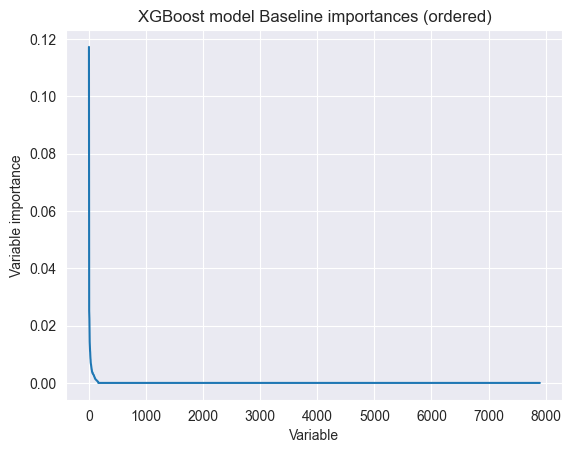

In [3]:
baseline = XGBClassifier()
baseline.fit(train_spam, labels_train_spam)
plt.plot(np.sort(baseline.feature_importances_)[::-1])
plt.title("XGBoost model Baseline importances (ordered)")
plt.ylabel("Variable importance")
plt.xlabel("Variable")
plt.show()

In [4]:
baseline_acc = cross_val_score(baseline, train_spam, labels_train_spam, scoring="balanced_accuracy")
print(baseline_acc)
print(np.mean(baseline_acc))

[0.93993287 0.92900037 0.91834327 0.9271713  0.93929676]
0.9307489140241436


# Boruta

In [5]:
def relu(x):
    return np.maximum(0., x)

def artificial_scoring(ba, m):
    return ba - .01 * relu(m/100 - 1)

In [6]:
boruta_fs = BorutaPy(
    RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5),
    n_estimators='auto', verbose=1, random_state=1)
boruta_fs.fit(train_spam.values, labels_train_spam.ravel())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=387, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2165CC1F440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2165CC1F440, verbose=1)

In [7]:
boruta_simple_cv_score = cross_val_score(
    XGBClassifier(), 
    boruta_fs.transform(train_spam.values), 
    np.array(labels_train_spam).flatten(), 
    scoring="balanced_accuracy"
)
print(boruta_simple_cv_score)

[0.93713045 0.92493533 0.92843393 0.94829442 0.93523172]


In [8]:
boruta_fs.n_features_

158

In [9]:
artificial_scoring(np.mean(boruta_simple_cv_score), boruta_fs.n_features_) # expected score

0.9290051703095084

# Trimming search space
Primarily to save time, it seems only 20 features are even worth looking at.

In [10]:
np.sum(boruta_fs.ranking_ < 35)

200

In [11]:
trim_art = train_spam.loc[:, boruta_fs.ranking_ < 35]
trim_art

,00,000,08000839402,10,100,1000,10p,12hrs,150,150p,...,winner,with,wk,wkly,won,word,work,www,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# RFE

In [12]:
def art_scorer(est, X, y):
    yhat = est.predict(X)
    return artificial_scoring(
        balanced_accuracy_score(y, yhat),
        np.sum(est.feature_importances_ != 0.)
    )

In [13]:
rfe_fs = RFECV(
    XGBClassifier(),
    step=1,
    min_features_to_select=100,
    scoring=art_scorer
)

In [14]:
rfe_fs.fit(trim_art.values, labels_train_spam.ravel())

RFECV(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      min_features_to_select=100,
      scoring=<function art_scorer at 0x000002165E48A560>)

In [15]:
rfe_fs.cv_results_

{'mean_test_score': array([0.93184777, 0.9328733 , 0.93027428, 0.92978006, 0.9295538 ,
        0.93018055, 0.92899501, 0.93229996, 0.93125403, 0.93136029,
        0.93132029, 0.93222623, 0.93207996, 0.93218623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.93216623, 0.93216623, 0.93216623, 0.93216623,
        0.93216623, 0.9321662

In [16]:
max(rfe_fs.cv_results_["mean_test_score"]) # expected score

0.9328733007946882

In [17]:
np.argmax(rfe_fs.cv_results_["mean_test_score"]) + 100 # expected n_features

101

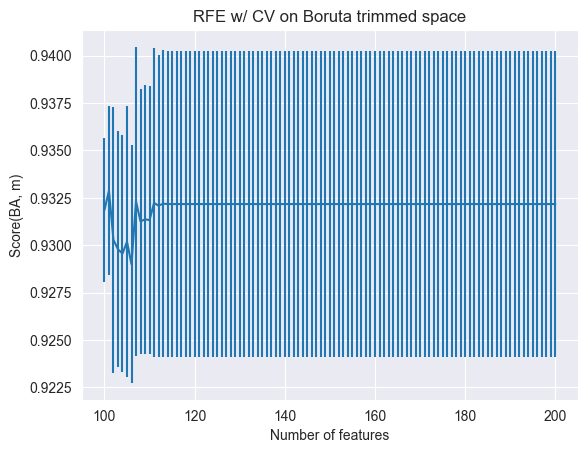

In [18]:
plt.errorbar(np.arange(0, len(rfe_fs.cv_results_["mean_test_score"])) + 100, rfe_fs.cv_results_["mean_test_score"], yerr=rfe_fs.cv_results_["std_test_score"])
plt.title("RFE w/ CV on Boruta trimmed space")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

# ReliefF
2 and 4 nearest neighbors

In [19]:
relief2n_fs = skrebate.ReliefF(n_features_to_select=20, n_neighbors=2, n_jobs=-1)
relief4n_fs = skrebate.ReliefF(n_features_to_select=20, n_neighbors=4, n_jobs=-1)

In [20]:
relief2n_fs.fit(trim_art.values.astype("float"), labels_train_spam.ravel())
relief4n_fs.fit(trim_art.values.astype("float"), labels_train_spam.ravel())

ReliefF(n_features_to_select=20, n_jobs=-1, n_neighbors=4)

In [21]:
relief2n_slide_results = []
relief2n_slide_indexes = []

for i in range(100, 200):
    relief2n_fs.set_params(n_features_to_select=i)
    relief_data = relief2n_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, labels_train_spam.ravel(), scoring="balanced_accuracy")
    relief2n_slide_results.append(BA_cv)
    relief2n_slide_indexes.append(i)

    
relief2n_df = pd.DataFrame(relief2n_slide_results)
relief2n_df = pd.concat((
    relief2n_df,
    relief2n_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": relief2n_slide_indexes})
), axis=1)

In [22]:
relief2n_df["mean_score"] = artificial_scoring(relief2n_df["mean"], relief2n_df["n_features"])
print(max(relief2n_df["mean_score"])) # expected score
print(relief2n_df[relief2n_df["mean_score"] == max(relief2n_df["mean_score"])]["n_features"].values[0]) # n_features

0.9346457346898169
114


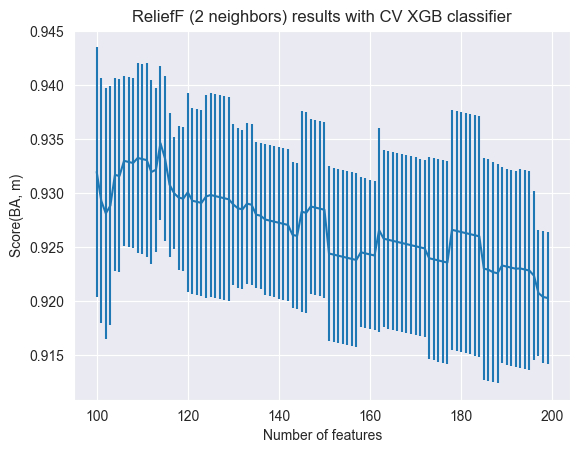

In [23]:
plt.errorbar(relief2n_df["n_features"], relief2n_df["mean_score"], yerr=relief2n_df["std"])
plt.title("ReliefF (2 neighbors) results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

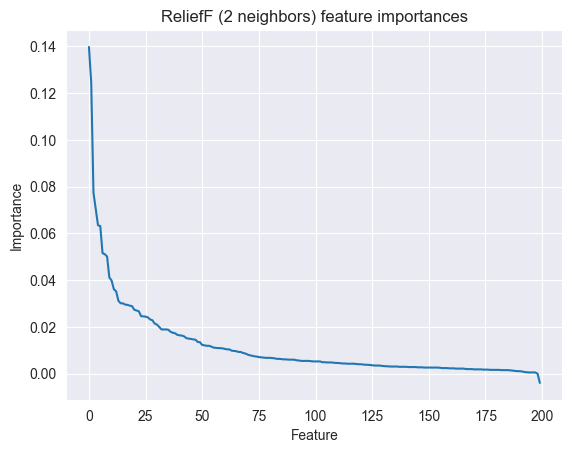

In [24]:
plt.plot(np.sort(relief2n_fs.feature_importances_)[::-1])
plt.title("ReliefF (2 neighbors) feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [25]:
relief4n_slide_results = []
relief4n_slide_indexes = []

for i in range(100, 200):
    relief4n_fs.set_params(n_features_to_select=i)
    relief_data = relief4n_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, labels_train_spam.ravel(), scoring="balanced_accuracy")
    relief4n_slide_results.append(BA_cv)
    relief4n_slide_indexes.append(i)

    
relief4n_df = pd.DataFrame(relief4n_slide_results)
relief4n_df = pd.concat((
    relief4n_df,
    relief4n_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": relief4n_slide_indexes})
), axis=1)


In [26]:
relief4n_df["mean_score"] = artificial_scoring(relief4n_df["mean"], relief4n_df["n_features"])
print(max(relief4n_df["mean_score"])) # expected score
print(relief4n_df[relief4n_df["mean_score"] == max(relief4n_df["mean_score"])]["n_features"].values[0]) # n_features

0.9332010206743644
107


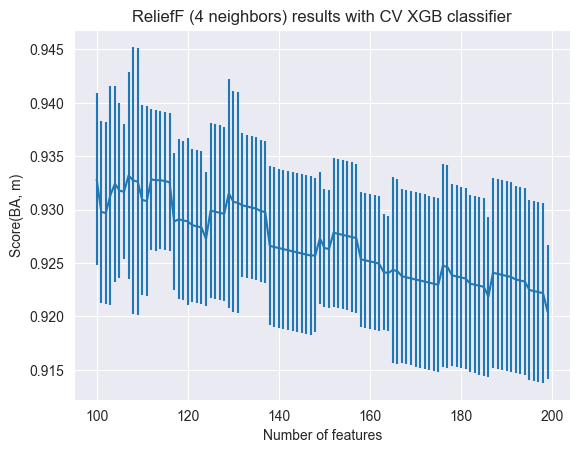

In [27]:
plt.errorbar(relief4n_df["n_features"], relief4n_df["mean_score"], yerr=relief4n_df["std"])
plt.title("ReliefF (4 neighbors) results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

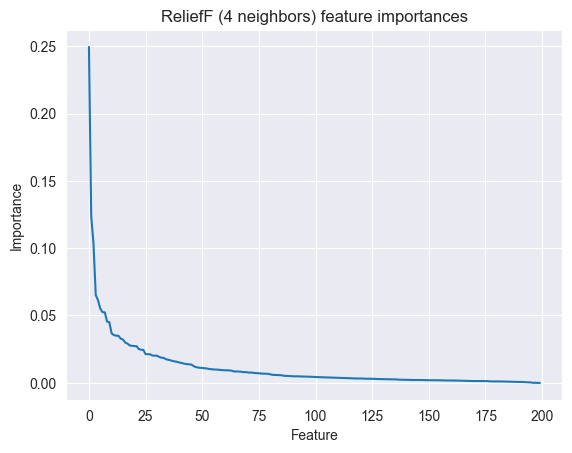

In [28]:
plt.plot(np.sort(relief4n_fs.feature_importances_)[::-1])
plt.title("ReliefF (4 neighbors) feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

# TuRF

In [29]:
turf_fs = skrebate.TuRF(
    core_algorithm="ReliefF", n_features_to_select=20, pct=0.25, n_jobs=-1
).fit(
    np.array(trim_art).astype("float"), 
    np.array(labels_train_spam).flatten(),
    headers=list(trim_art)
)

In [30]:
turf_slide_results = []
turf_slide_indexes = []

for i in range(100, 200):
    turf_fs.set_params(n_features_to_select=i)
    relief_data = turf_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, labels_train_spam.ravel(), scoring="balanced_accuracy")
    turf_slide_results.append(BA_cv)
    turf_slide_indexes.append(i)

    
turf_df = pd.DataFrame(turf_slide_results)
turf_df = pd.concat((
    turf_df,
    turf_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": turf_slide_indexes})
), axis=1)


In [31]:
turf_df["mean_score"] = artificial_scoring(turf_df["mean"], turf_df["n_features"])
print(max(turf_df["mean_score"])) # expected score
print(turf_df[turf_df["mean_score"] == max(turf_df["mean_score"])]["n_features"].values[0]) # n_features

0.9281388142619313
100


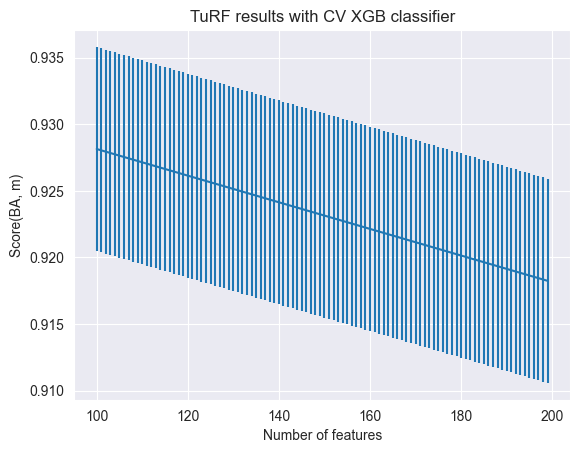

In [32]:
plt.errorbar(turf_df["n_features"], turf_df["mean_score"], yerr=turf_df["std"])
plt.title("TuRF results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

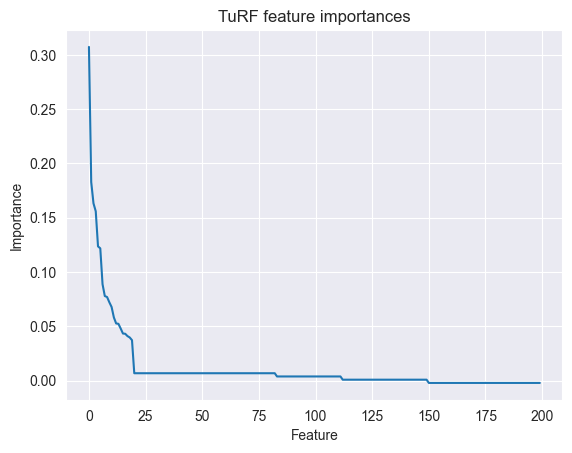

In [33]:
plt.plot(np.sort(turf_fs.feature_importances_)[::-1])
plt.title("TuRF feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [34]:
xbc = XGBClassifier()

In [35]:
relief2n_fs.set_params(n_features_to_select=114)
X_final = relief2n_fs.transform(trim_art.values.astype("float"))

In [36]:
xbc.fit(X_final, labels_train_spam)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
test_spam = get_spam_test_data('data/sms_test.csv', cv_train)

In [38]:
answers = xbc.predict_proba(
    relief2n_fs.transform(test_spam.loc[:, boruta_fs.ranking_ < 35].values.astype("float"))
)[:,1]

In [39]:
idx = boruta_fs.ranking_ < 35

In [40]:
features = np.where(idx)[0][relief2n_fs.top_features_[:relief2n_fs.n_features_to_select]]

In [49]:
from data_preparation import write_answer, write_indices

write_answer('JAKFOL_spam_prediction.txt', answers)
write_indices('JAKFOL_spam_features.txt', repr(list(features)))